In [ ]:
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mplfinance

In [ ]:
# Import necessary libraries
import mplfinance as mpf
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam
from keras.callbacks import Callback
from matplotlib.dates import date2num


In [ ]:
# Corrected file path
file_path = '/content/drive/MyDrive/Fyp_Testing/BTC.csv'

# Load the CSV file into a pandas DataFrame
try:
    data = pd.read_csv(file_path)
    print("File loaded successfully!")
    print(data.head())
except FileNotFoundError as e:
    print(f"Error: {e}")

# Convert 'Open Time' to datetime
data['Open Time'] = pd.to_datetime(data['Open Time'])

# Check the updated data to ensure conversion is correct
print("Data after datetime conversion:")
print(data.head())


File loaded successfully!
             Open Time      Open      High       Low     Close   Volume  \
0  2019-09-08 17:00:00  10000.00  10000.00  10000.00  10000.00    0.002   
1  2019-09-08 18:00:00  10000.00  10000.00  10000.00  10000.00    0.000   
2  2019-09-08 19:00:00  10344.77  10357.53  10337.43  10340.12  471.659   
3  2019-09-08 20:00:00  10340.12  10368.64  10334.54  10351.42  583.271   
4  2019-09-08 21:00:00  10351.42  10391.90  10324.77  10391.90  689.759   

   Quote Asset Volume  
0        2.000000e+01  
1        0.000000e+00  
2        4.879792e+06  
3        6.037733e+06  
4        7.136799e+06  
Data after datetime conversion:
            Open Time      Open      High       Low     Close   Volume  \
0 2019-09-08 17:00:00  10000.00  10000.00  10000.00  10000.00    0.002   
1 2019-09-08 18:00:00  10000.00  10000.00  10000.00  10000.00    0.000   
2 2019-09-08 19:00:00  10344.77  10357.53  10337.43  10340.12  471.659   
3 2019-09-08 20:00:00  10340.12  10368.64  10334.54

In [ ]:
# Separate scaling for features and target (Include 'Close' as a feature)
scaler_feature = StandardScaler()
scaler_target = StandardScaler()

# Separate features and target (Include 'Close' as a feature)
X_features = data[['Open', 'High', 'Low', 'Quote Asset Volume', 'Close']].values
y_target = data['Close'].values.reshape(-1, 1)

# Scale features (Open, High, Low, Quote Asset Volume, Close)
scaled_features = scaler_feature.fit_transform(X_features)

# Scale the target (Close) separately
scaled_target = scaler_target.fit_transform(y_target)


In [ ]:
# Create dataset
def create_dataset(data, target, window_size=4):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])  # Input: Previous 4-hour features (including 'Close')
        y.append(target[i + window_size])  # Target: Next hour's 'Close' price
    return np.array(X), np.array(y)

# Prepare dataset
X, y = create_dataset(scaled_features, scaled_target)

# Reshape for LSTM
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("Training set shapes:", X_train.shape, y_train.shape)
print("Testing set shapes:", X_test.shape, y_test.shape)


Training set shapes: (7996, 4, 5) (7996, 1)
Testing set shapes: (2000, 4, 5) (2000, 1)


In [ ]:
# Define the LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Use Adam optimizer with a learning rate scheduler (default learning rate can be adjusted)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = create_model()
# Display model summary
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_64 (LSTM)                       │ (None, 4, 100)              │          42,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 4, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_65 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,901 (480.08 KB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Custom callback to print the current epoch and validation loss
class EpochEndCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']} - val_loss: {logs['val_loss']:.4f}")

# Create and use the custom callback
epoch_end_callback = EpochEndCallback()


Training the model...
Epoch 1/80
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1364Epoch 1/80 - val_loss: 0.0265
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.1349 - val_loss: 0.0265
Epoch 2/80
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092Epoch 2/80 - val_loss: 0.0086
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 3/80
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072Epoch 3/80 - val_loss: 0.0048
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 4/80
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0065Epoch 4/80 - val_loss: 0.0058
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 5/80
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0065Epoch 5/80 - val_loss: 0.0069
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 6/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0056Epoch 6/80 - val_loss: 0.0088
125/125 ━━━━━━━━

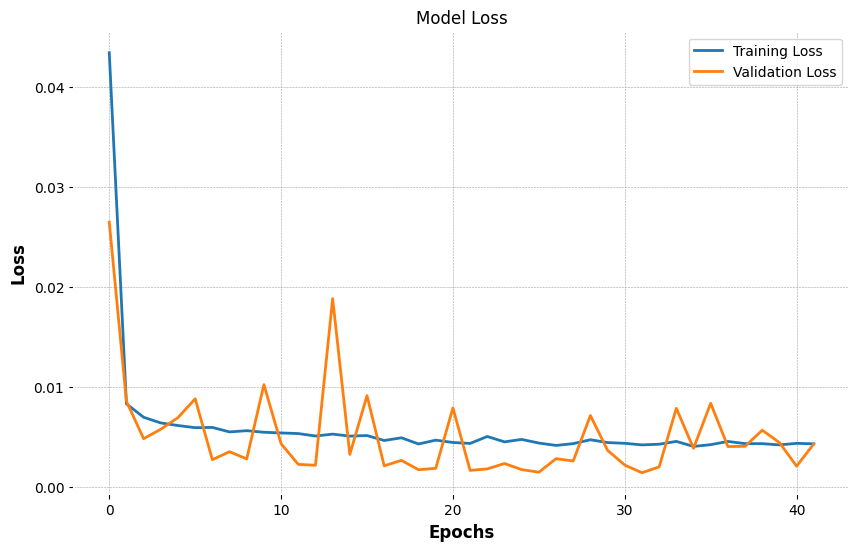

In [ ]:
# Train the model with early stopping and model checkpointing
print("Training the model...")
history = model.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint, epoch_end_callback])

# Retrieve the training history
history = model.history.history

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Print current best epoch and loss
best_epoch = np.argmin(history['val_loss']) + 1  # Adding 1 to match epoch number
print(f"Best Epoch: {best_epoch}, Best Validation Loss: {history['val_loss'][best_epoch - 1]:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the actual and predicted values
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))  # Inverse scale the actual Close price
y_pred_actual = scaler_target.inverse_transform(y_pred)  # Inverse scale the predicted Close price

# Print first few values for verification
print("First few actual values after inverse scaling:", y_test_actual.flatten()[:5])
print("First few predicted values after inverse scaling:", y_pred_actual.flatten()[:5])


Best Epoch: 32, Best Validation Loss: 0.0014
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
First few actual values after inverse scaling: [11832.23 11867.84 11832.95 11823.16 11793.  ]
First few predicted values after inverse scaling: [11788.321 11811.45  11844.692 11856.548 11831.787]


In [ ]:
# Ensure proper alignment of arrays
trades = []  # List to store trade execution status for each prediction
total_trades = 0  # Total number of trades considered
executed_trades = 0  # Total number of trades executed
non_executed_trades = 0  # Total number of trades not executed
win_count = 0  # Count of winning trades

# Lists to store actual high, low, and close values for display
highs = []
lows = []
closes = []

# Start looping from 1 to avoid index out of range (comparing to previous close)
for i in range(1, len(y_pred_actual)):
    total_trades += 1  # Count each trade attempt
    predicted_close = y_pred_actual[i][0]  # Predicted close for the current step
    actual_close = y_test_actual[i][0]  # Actual close for the current step
    previous_close = y_test_actual[i - 1][0]  # Previous close to compare for trade type

    # Get the candlestick data (Open, High, Low, Close) for the current time step
    actual_open = data['Open'].iloc[i + len(X_train)]  # Adjusting index for correct test set row
    actual_high = data['High'].iloc[i + len(X_train)]
    actual_low = data['Low'].iloc[i + len(X_train)]

    # Store actual high, low, and close values for display later
    highs.append(actual_high)
    lows.append(actual_low)
    closes.append(actual_close)

    # Determine trade type (Long or Short)
    if predicted_close > previous_close:  # Long trade
        trade_type = 'Long'
        # Check if the candlestick high has touched or crossed the predicted close
        if predicted_close <= actual_high:
            executed_trades += 1
            trades.append("Executed - Long")
            # If the predicted close is higher than the actual close, it's a winning trade
            if predicted_close > actual_close:
                win_count += 1
        else:
            non_executed_trades += 1
            trades.append("Not Executed - Long")
    elif predicted_close < previous_close:  # Short trade
        trade_type = 'Short'
        # Check if the candlestick low has touched or crossed the predicted close
        if predicted_close >= actual_low:
            executed_trades += 1
            trades.append("Executed - Short")
            # If the predicted close is lower than the actual close, it's a winning trade
            if predicted_close < actual_close:
                win_count += 1
        else:
            non_executed_trades += 1
            trades.append("Not Executed - Short")

    # Debugging: print actual values from data
    print(f"Step {i + 1}:")
    print(f"Predicted Close: {predicted_close}")
    print(f"Actual Close: {actual_close}")
    print(f"Previous Close: {previous_close}")
    print(f"Candlestick Data - Open: {actual_open}, High: {actual_high}, Low: {actual_low}")
    print(f"Trade Type: {trade_type}")
    print(f"Trade Execution Status: {trades[-1]}")
    print("\n" + "-"*50 + "\n")



Streaming output truncated to the last 5000 lines.
Step 1501:
Predicted Close: 10617.1337890625
Actual Close: 10731.86
Previous Close: 10633.53
Candlestick Data - Open: 10557.06, High: 10573.0, Low: 10523.0
Trade Type: Short
Trade Execution Status: Executed - Short

--------------------------------------------------

Step 1502:
Predicted Close: 10699.328125
Actual Close: 10909.99
Previous Close: 10731.86
Candlestick Data - Open: 10558.48, High: 10627.09, Low: 10553.5
Trade Type: Short
Trade Execution Status: Executed - Short

--------------------------------------------------

Step 1503:
Predicted Close: 10870.2412109375
Actual Close: 10892.69
Previous Close: 10909.99
Candlestick Data - Open: 10602.43, High: 10605.0, Low: 10588.91
Trade Type: Short
Trade Execution Status: Executed - Short

--------------------------------------------------

Step 1504:
Predicted Close: 10914.46484375
Actual Close: 10916.64
Previous Close: 10892.69
Candlestick Data - Open: 10598.99, High: 10645.0, Low: 1

In [ ]:
# Calculate win rate based on executed trades
win_rate = (win_count / executed_trades) * 100 if executed_trades > 0 else 0

# Now, ensure the trade results are aligned with the data length
# Adjust y_pred_actual and y_test_actual to match the range
trade_results = pd.DataFrame({
    'Predicted Close Price': y_pred_actual[1:].flatten(),  # Skip first element for comparison
    'Actual Close Price': y_test_actual[1:].flatten(),  # Skip first element for comparison
    'Actual High': highs,
    'Actual Low': lows,
    'Actual Close': closes,
    'Trade Executed': trades
})

# Display the trade summary
print(f"Total Trades: {total_trades}")
print(f"Executed Trades: {executed_trades}")
print(f"Non-Executed Trades: {non_executed_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print("Trade Execution Results:")
print(trade_results.head())


Total Trades: 1999
Executed Trades: 1569
Non-Executed Trades: 430
Win Rate: 69.02%
Trade Execution Results:
   Predicted Close Price  Actual Close Price  Actual High  Actual Low  \
0           11811.450195            11867.84     11799.00    11714.71   
1           11844.692383            11832.95     11794.77    11707.82   
2           11856.547852            11823.16     11829.00    11743.57   
3           11831.787109            11793.00     11871.00    11795.83   
4           11811.313477            11816.45     11920.00    11829.00   

   Actual Close       Trade Executed  
0      11867.84     Executed - Short  
1      11832.95     Executed - Short  
2      11823.16  Not Executed - Long  
3      11793.00      Executed - Long  
4      11816.45      Executed - Long  


In [ ]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R² Score: {r2:.2f}")

# Calculate MAPE (Mean Absolute Percentage Error)
def calculate_mape(actual, predicted):
    epsilon = 1e-10  # Avoid division by zero
    mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100
    return mape

mape = calculate_mape(y_test_actual, y_pred_actual)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Root Mean Squared Error (RMSE): 60.71
R² Score: 0.99
Mean Absolute Percentage Error (MAPE): 0.35%


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


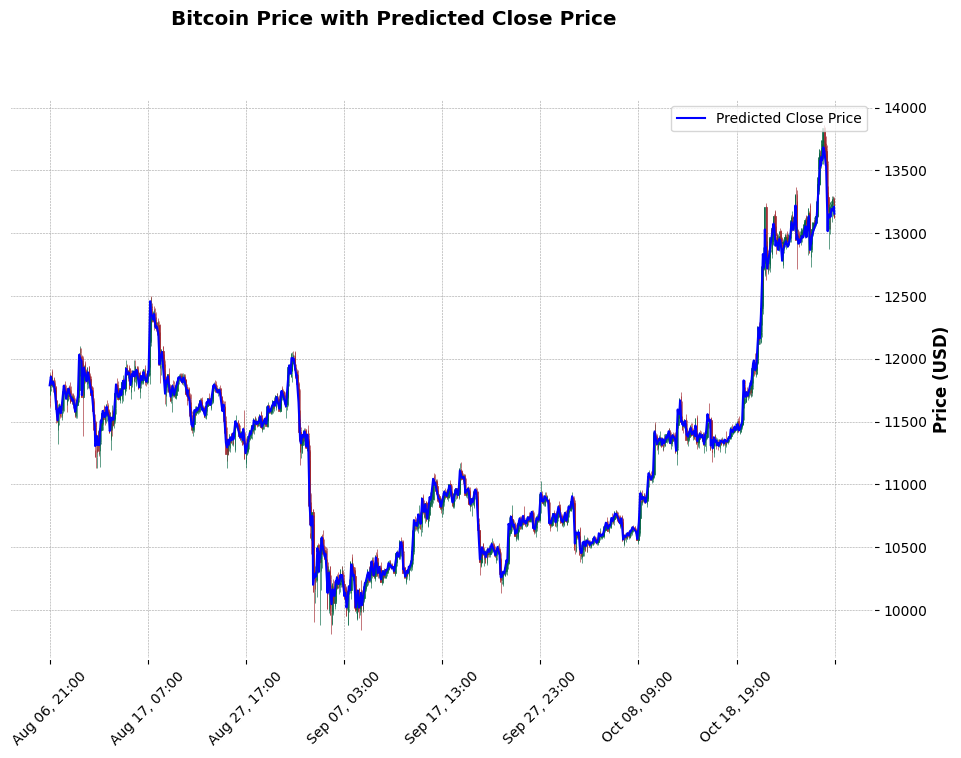

In [ ]:
# Plot Candlestick chart with Predicted Close as a line
# Prepare the data for candlestick plotting
ohlc_data = []
for i in range(len(y_test_actual)):
    timestamp = data['Open Time'].iloc[i + len(X_train)]
    open_price = data['Open'].iloc[i + len(X_train)]
    high_price = data['High'].iloc[i + len(X_train)]
    low_price = data['Low'].iloc[i + len(X_train)]
    close_price = y_test_actual[i][0]  # Actual close for the current step
    ohlc_data.append([timestamp, open_price, high_price, low_price, close_price])

# Convert the list to a DataFrame that mplfinance can work with
ohlc_df = pd.DataFrame(ohlc_data, columns=['Date', 'Open', 'High', 'Low', 'Close'])

# Ensure the 'Date' column is of datetime type and set it as the index
ohlc_df['Date'] = pd.to_datetime(ohlc_df['Date'])
ohlc_df.set_index('Date', inplace=True)

# Prepare the predicted close price for overlay
predicted_close = pd.Series(y_pred_actual.flatten(),
                            index=data['Open Time'].iloc[len(X_train):len(X_train)+len(y_test_actual)])

# Create an additional plot for the predicted close price line
ap = mpf.make_addplot(predicted_close, color='blue', linestyle='-', width=1.5, secondary_y=False, label='Predicted Close Price')

# Plot the candlestick chart with the predicted close price line
mpf.plot(ohlc_df, type='candle', style='charles', figsize=(12, 8),
         title='Bitcoin Price with Predicted Close Price',
         addplot=ap,
         ylabel='Price (USD)',
         volume=False)  # You can set volume=True if you have volume data

# Show the combined plot
plt.show()


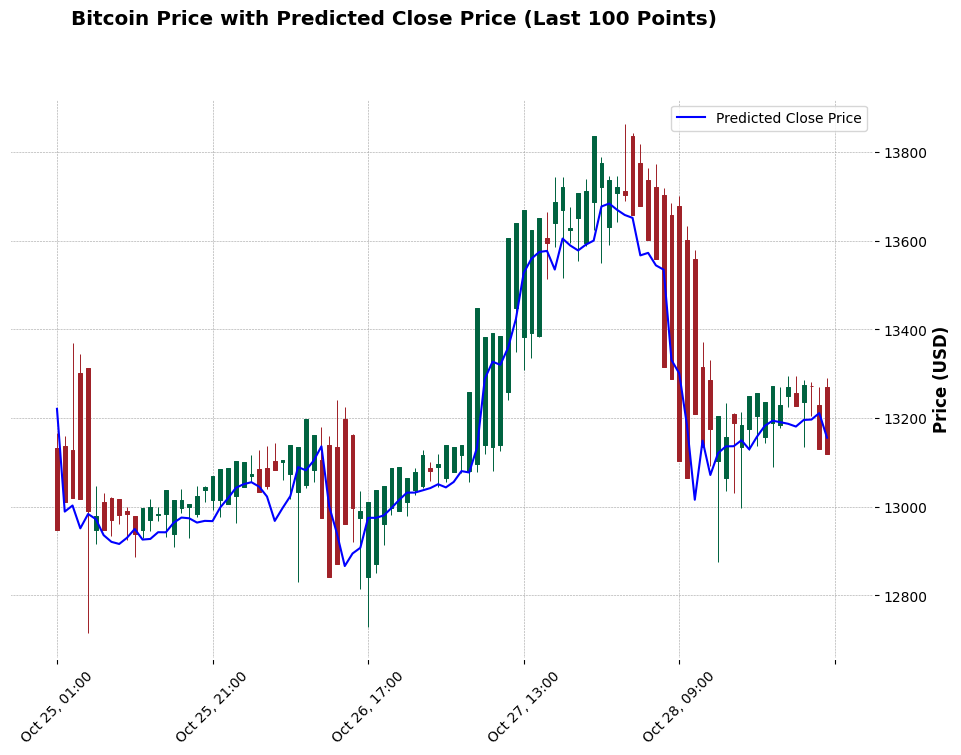

In [ ]:
# Zooming into the last 2000 data points
ohlc_df = ohlc_df.iloc[-100:]  # Take the last 2000 rows of the OHLC data
predicted_close = predicted_close.iloc[-100:]  # Take the last 2000 rows of the predicted close data

# Create an additional plot for the predicted close price line
ap = mpf.make_addplot(predicted_close, color='blue', linestyle='-', width=1.5, label='Predicted Close Price')

# Plot the candlestick chart with the predicted close price line
mpf.plot(ohlc_df, type='candle', style='charles', figsize=(12, 8),
         title='Bitcoin Price with Predicted Close Price (Last 100 Points)',
         addplot=ap,
         ylabel='Price (USD)',
         volume=False)  # You can set volume=True if you have volume data

# Show the combined plot
plt.show()
